# 1. AUTOGRAD: AUTOMATIC DIFFERENTIATION:

Central to all neural networks in PyTorch is the **autograd** package. Let’s first briefly visit this, and we
will then go to training our first neural network.
    
The **autograd** package provides automatic differentiation for all operations on Tensors. It is a define-by-
run framework, which means that your backprop is defined by how your code is run, and that every single 
iteration can be different.

## 1.1. Create a tensor and set requires_grad=True to track computation with it:
torch.Tensor is the central class of the package. If you set its attribute **.requires_grad** as **True**, it starts to track all operations on it. When you finish your computation you can call **.backward()** and have all the gradients computed automatically. The gradient for this tensor will be accumulated into **.grad** attribute.

define a function:  
x = \[[1,1],[1,1]]  
y = x + 2  
z = y ^ 2 * 3  
out = z.mean()  

In [2]:
import torch

# create a tensor with setting its .requires_grad as Ture
x = torch.ones(2, 2, requires_grad=True)
print(x)

x1 = torch.ones(2,2,requires_grad=False)
# x1.requires_grad_(True)
print(x1)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[1., 1.],
        [1., 1.]])


## 1.2. Do a tensor operation:

In [3]:
y = x + 2
print(y)

y1 = x1 + 2
print(y1)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[3., 3.],
        [3., 3.]])


y was created as a result of an operation, so it has a grad_fn.But y1 not

In [4]:
print(y.grad_fn)
print(y1.grad_fn)

None


## 1.3. Do more operations on y

In [5]:
z = y * y * 3
z1 = y1 * y1 * 3
out = z.mean()   #calculate z average value
out1 = z1.mean()   #calculate z1 average value

print(z, out)
print(z1, out1)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward1>)
tensor([[27., 27.],
        [27., 27.]]) tensor(27.)


**.requires_grad_( )** changes an existing Tensor’s requires_grad flag in-place. The input flag defaults to False if not given.

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of 
computation. Each tensor has a .grad_fn attribute that references a Function that has created the Tensor 
(**except for Tensors created by the user - their grad_fn is None**).

In [6]:
a = torch.randn(2, 2)    # a is created by user, its .grad_fn is None
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)   # change the attribute .grad_fn of a
print(a.requires_grad)
b = (a * a).sum()        # add all elements of a  to b
print(b.grad_fn)

False
True


# 2. Gradients:

## 2.1. Let’s backprop now. 
Because out contains a single scalar, **out.backward( )** is equivalent to **out.backward(torch.tensor(1.))**

In [7]:
out.backward()
# out.backward(torch.tensor(1.))
# out1.backward()

you can get parameters gradient like below:

In [8]:
x_grad = x.grad
y_grad = y.grad
z_grad = z.grad
print(x_grad)
print(y_grad)
print(z_grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
None


## 2.2. Now let’s take a look at an example of Jacobian-vector product:
If you want to compute the derivatives, you can call **.backward( )** on a Tensor. If Tensor is a **scalar** (i.e. it holds a one element data), you don’t need to specify any arguments to backward( ), however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

define a function:  
x = \[1, 1, 1]  
y = x + \[1, 2, 3]  
z = y ^ 3

In [9]:
x = torch.ones(3, requires_grad=True)
y = x + torch.tensor([1., 2., 3.])
z = y * y * y
print(z)

v = torch.tensor([1, 0.1, 0.01])
# z is a vector, so you need to specify a gradient whose size is the same as z
z.backward(v)    
print(x.grad)

tensor([ 8., 27., 64.], grad_fn=<MulBackward0>)
tensor([12.0000,  2.7000,  0.4800])


## 问题1：
**传入 .backward()里面的tensor是什么？请尝试不同的输入并回答。**

v可以理解为z中个分量的权重，在我们传进参数v的时候，我们这里可以将backward这个过程看作是(zv)对x求偏导。

# 3. NEURAL NETWORKS

A typical training procedure for a neural network is as follows:
    
- Define the neural network that has some learnable parameters (or weights)
- Iterate over a dataset of inputs
- Process input through the network
- Empty the parameters in optimizer
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient


## 3.1. Define the network
Let’s define a network to classify points of gaussian distribution to three class

### 3.1.1. Show all points
Show all points(containing trainset and testset) you will use

In [10]:
# show all points, you can skip this cell
def show_original_points():
    label_csv = open('./labels/label.csv', 'r')
    label_writer = csv.reader(label_csv)
    class1_point = []
    class2_point = []
    class3_point = []
    for item in label_writer:
        if item[2] == '0':
            class1_point.append([item[0], item[1]])
        elif item[2] == '1':
            class2_point.append([item[0], item[1]])
        else:
            class3_point.append([item[0], item[1]])
    data1 = np.array(class1_point, dtype=float)
    data2 = np.array(class2_point, dtype=float)
    data3 = np.array(class3_point, dtype=float)
    x1, y1 = data1.T
    x2, y2 = data2.T
    x3, y3 = data3.T
    plt.figure()
    plt.scatter(x1, y1, c='b', marker='.')
    plt.scatter(x2, y2, c='r', marker='.')
    plt.scatter(x3, y3, c='g', marker='.')
    plt.axis()
    plt.title('scatter')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

### 3.1.2. Define a network
When you define a network, your class must to inherit **nn.Moudle**, then you should to overload **\_\_init__** method and **forward** method

Network(  
    (hidden): Linear(in_features=2, out_features=5, bias=True)  
    (sigmiod): Sigmoid()  
    (predict): Linear(in_features=5, out_features=3, bias=True)  
)  

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import csv
import numpy as np

In [12]:
class Network(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        '''
        Args:
            n_feature(int): size of input tensor
            n_hidden(int): size of hidden layer 
            n_output(int): size of output tensor
        '''
        super(Network, self).__init__()
        # define a liner layer
        self.hidden = nn.Linear(n_feature, n_hidden)
        # define sigmoid activation 
        self.sigmoid = nn.Sigmoid()
        self.predict = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        '''
        x(tensor): inputs of the network
        '''
        # hidden layer
        h1 = self.hidden(x)
        # activate function
        h2 = self.sigmoid(h1)
        # output layer
        out = self.predict(h2)
        '''
        Linear classifier often follows softmax to output probability,
        however the loss function CrossEntropy we used have done this 
        operation, so we don't use softmax function here.
        '''
        return out

CrossEntropy written in pytorch:
[https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss)

### 3.1.3. Overload a Dataset
Please skip the below cell when you are trying to train a model

In [13]:
class PointDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        '''
        Args:
            csv_file(string): path of label file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        '''
        self.frame = pd.read_csv(csv_file, encoding='utf-8', header=None)
        print('csv_file source ---->', csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        x = self.frame.iloc[idx, 0]
        y = self.frame.iloc[idx, 1]
        point = np.array([x, y])
        label = int(self.frame.iloc[idx, 2])
        if self.transform is not None:
            point = self.transform(point)
        sample = {'point': point, 'label': label}
        return sample

### 3.1.4. Train function
Train a model and show running_loss curve ana show accuracy curve

In [14]:
def train(classifier_net, trainloader, testloader, device, lr, optimizer):
    '''
    Args:
        classifier_net(nn.model): train model
        trainloader(torch.utils.data.DateLoader): train loader
        testloader(torch.utils.data.DateLoader): test loader
        device(torch.device): the evironment your model training
        LR(float): learning rate
    '''
    # loss function
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = optimizer
    
    # save the mean value of loss in an epoch
    running_loss = []
    
    running_accuracy = []
    
    # count loss in an epoch 
    temp_loss = 0.0
    
    # count the iteration number in an epoch
    iteration = 0 

    for epoch in range(epoches):
        
        '''
        adjust learning rate when you are training the model
        '''
        # adjust learning rate
        # if epoch % 100 == 0 and epoch != 0:
        #     LR = LR * 0.1
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = LR

        for i, data in enumerate(trainloader):
            point, label = data['point'], data['label']
            point, label = point.to(device).to(torch.float32), label.to(device)
            outputs = classifier_net(point)
            '''# TODO'''
            
            optimizer.zero_grad()
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            
            
            '''# TODO END'''
            
            # save loss in a list
            temp_loss += loss.item()
            iteration +=1
            # print loss value 
#             print('[{0:d},{1:5.0f}] loss {2:.5f}'.format(epoch + 1, i, loss.item()))
            #slow down speed of print function
            # time.sleep(0.5)
        running_loss.append(temp_loss / iteration)
        temp_loss = 0
        iteration = 0
        print('test {}:----------------------------------------------------------------'.format(epoch))
        
        # call test function and return accuracy
        running_accuracy.append(predict(classifier_net, testloader, device))
    
    # show loss curve
    show_running_loss(running_loss)
    
    # show accuracy curve
    show_accuracy(running_accuracy)
    
    return classifier_net

## 问题2:
根据本节前面提到的训练一个网络的完整流程，将下面的代码按照正确的顺序填写到train()函数里面的 **\# TODO** 里面  

\# update paraeters in optimizer(update weigtht)  
**optimizer.step()**  


\# calcutate loss value  
**loss = criterion(outputs, label)** 


\# empty parameters in optimizer  
**optimizer.zero_grad()**  

            
\# back propagation  
**loss.backward()**  





In [15]:
# show running loss curve, you can skip this cell.
def show_running_loss(running_loss):
    # generate x value
    x = np.array([i for i in range(len(running_loss))])
    # generate y value
    y = np.array(running_loss)
    # define a graph
    plt.figure()
    # generate curve
    plt.plot(x, y, c='b')
    # show axis
    plt.axis()
    # define title
    plt.title('loss curve:')
    #define the name of x axis
    plt.xlabel('step')
    plt.ylabel('loss value')
    # show graph
    plt.show()

### 3.1.5. Test function
Test the performance of your model 

In [16]:
def predict(classifier_net, testloader, device):
#     correct = [0 for i in range(3)]
#     total = [0 for i in range(3)]
    correct = 0
    total = 0
    
    with torch.no_grad():
        '''
        you can also stop autograd from tracking history on Tensors with .requires_grad=True 
        by wrapping the code block in with torch.no_grad():
        '''
        for data in testloader:
            point, label = data['point'], data['label']
            point, label = point.to(device).to(torch.float32), label.to(device)
            outputs = classifier_net(point)
            '''
            if you want to get probability of the model prediction,
            you can use softmax function here to transform outputs to probability.
            '''
            # transform the prediction to one-hot form
            _, predicted = torch.max(outputs, 1)
            print('model prediction: ', predicted)
            print('ground truth:', label, '\n')
            correct += (predicted == label).sum()
            total += label.size(0)
            print('current correct is:', correct.item())
            print('current total is:', total)
            
        print('the accuracy of the model is {0:5f}'.format(correct.item()/total))
        
    return correct.item() / total

In [17]:
# show accuracy curve, you can skip this cell.
def show_accuracy(running_accuracy):
    x = np.array([i for i in range(len(running_accuracy))])
    y = np.array(running_accuracy)
    plt.figure()
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('accuracy curve:')
    plt.xlabel('step')
    plt.ylabel('accuracy value')
    plt.show()

### 3.1.6. Main function

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


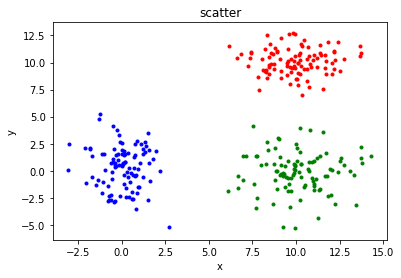

test 0:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 5
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 15
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 22
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 32
current total is: 64
model prediction:  te

test 6:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 28
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 41
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 56
current total is: 64
model prediction:  t

the accuracy of the model is 0.933333
test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 31
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 45
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
cu

the accuracy of the model is 0.966667
test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 46
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 62
cu

the accuracy of the model is 0.977778
test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
cu

test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  

test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  

test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  

the accuracy of the model is 0.988889
test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
cu

current total is: 80
model prediction:  tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0')
ground truth: tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 89
current total is: 90
the accuracy of the model is 0.988889
test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is:

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

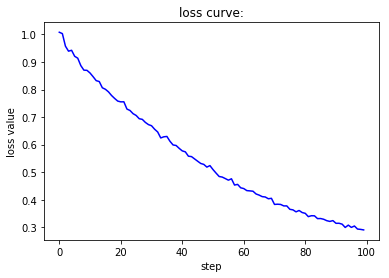

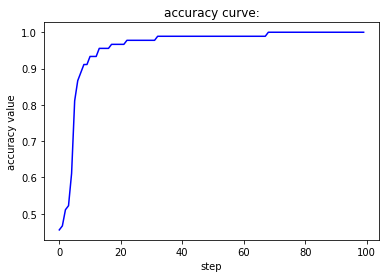

In [18]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题3:
**请尝试调整不同大小的学习率，观察loss曲线和accuracy曲线，并阐述学习率对loss值以及accuracy值的影响和原因。**

1. 在学习率从1e-4变到le-1过程当中,loss值的下降变得越来越快,在迭代次数比较少的时候loss值可以降得比较低,accuracy同样很快达到一个比较高的水平.在学习率高的时候模型收敛的速度很快，但收敛之后会存在局部波动，但理论上模型的准确率不会有这么高，因为在最后模型的梯度更新得太大，容易跳过极值点，在极值点附近摇摆。
2. 原因:在学习率较大的情况下,模型收敛很快，梯度下降的幅度比较大,可能会错过极值点,所以在学习率大的时候迭代较少次数就能得到较高的准确率;相应地,当学习率比较小的时候,梯度下降得比较慢,模型收敛很慢，迭代比较多的次数才能取得较高的准确率,并且由于下降梯度小，不容易错过极值点,学习率低的时候得到的loss更少,准确率也会越高.

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


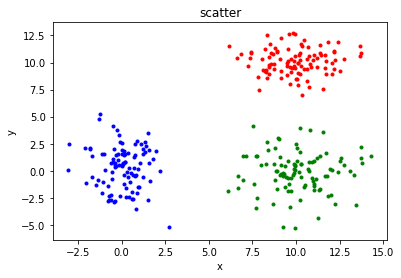

test 0:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 42
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 57
current total is: 64
model prediction:  t

test 6:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  t

test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

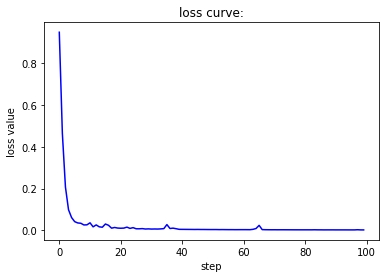

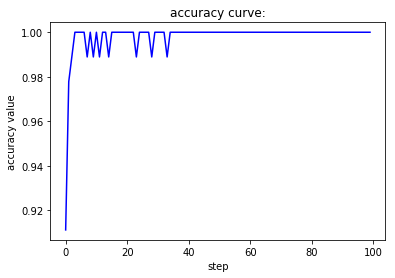

In [45]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-1
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


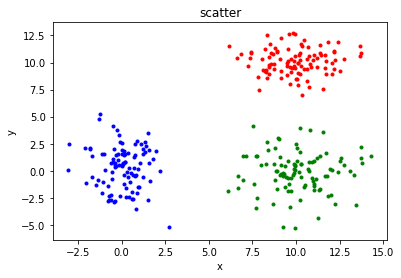

test 0:----------------------------------------------------------------
model prediction:  tensor([2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 6
current total is: 16
model prediction:  tensor([2, 0, 2, 1, 2, 2, 1, 1, 2, 2, 1, 0, 0, 1, 1, 2], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 16
current total is: 32
model prediction:  tensor([1, 2, 1, 2, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 24
current total is: 48
model prediction:  tensor([1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 31
current total is: 64
model prediction:  te

test 6:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 8
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 22
current total is: 32
model prediction:  tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 33
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 46
current total is: 64
model prediction:  te

the accuracy of the model is 0.666667
test 12:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 8
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 22
current total is: 32
model prediction:  tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 33
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 46
cur

the accuracy of the model is 1.000000
test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

the accuracy of the model is 1.000000
test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

current total is: 90
the accuracy of the model is 1.000000
test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

curr

test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

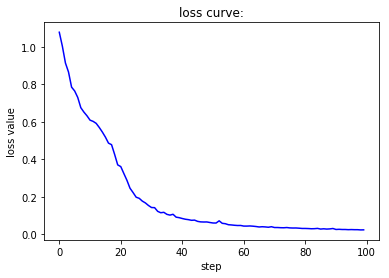

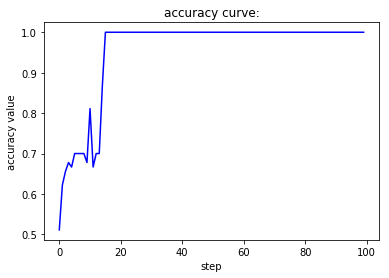

In [26]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-2
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


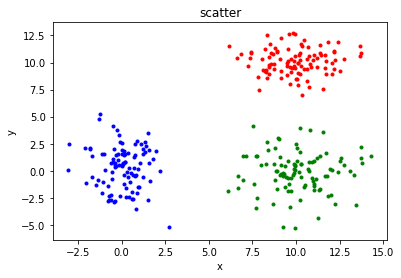

test 0:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  te

test 6:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  te

test 12:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  t

test 18:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  t

the accuracy of the model is 0.333333
test 24:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
cur

test 30:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  t

the accuracy of the model is 0.333333
test 36:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
cur

test 42:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  t

the accuracy of the model is 0.344444
test 48:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 11
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 15
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 24
cur

test 54:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 11
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 15
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 24
current total is: 64
model prediction:  t

the accuracy of the model is 0.366667
test 60:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 4
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 17
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 26
cur

the accuracy of the model is 0.377778
test 66:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 4
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 17
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 26
cur

the accuracy of the model is 0.422222
test 72:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 5
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 13
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 18
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 28
cur

test 78:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 5
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 14
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 19
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 29
current total is: 64
model prediction:  t

test 84:----------------------------------------------------------------
model prediction:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 6
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 15
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 20
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 30
current total is: 64
model prediction:  t

test 90:----------------------------------------------------------------
model prediction:  tensor([1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 8
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 17
current total is: 32
model prediction:  tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 24
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 36
current total is: 64
model prediction:  t

the accuracy of the model is 0.622222
test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 11
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 20
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 29
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 41
cu

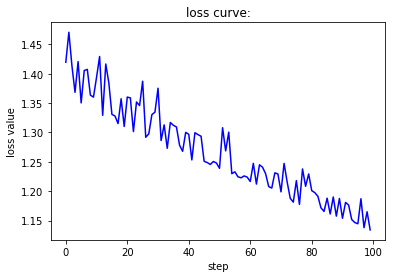

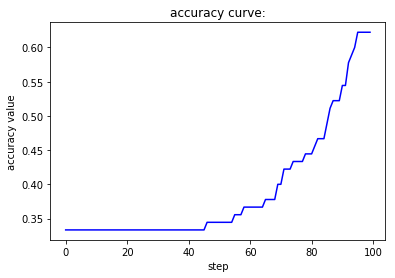

In [27]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-4
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题4:
**请尝试调整不同的batch_size, batch_size=1, batch_size=210,batch_size=（1~210）, 并阐述batch_size对loss值以及accuracy值的影响和原因。**

1. 在batch_size较小的时候,模型收敛得很快,但它的缺点是容易陷入局部极值点，导致不能收敛,因为单个样本不能代替全局下降的梯度下降的方向,所以梯度下降的方向有一的随机性,并且波动会比较大.但这里数据跑出来的结果并没有波动，理论上在batch_size小的时候梯度下降的反向是比较随机的，也就是会波动，我觉得这个数据集可能不具有代表性。
2. 在一定范围内,随着随着batch_size的增加,模型收敛得越来越慢,这时候梯度下降的方向会更加准确,因为batch的数据求得平均值以后能一定程度代表全局梯度下降的方向,但这样模型收敛得比较慢，而模型能得到更高准确率的潜力会越高。

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


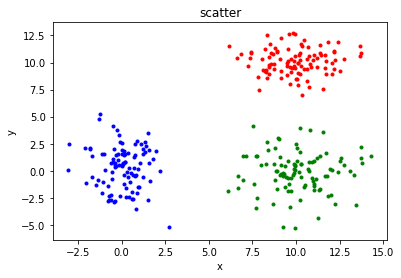

test 0:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 7
cur

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 58
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 60
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 61
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 62
current total is: 72
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 62
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 63
current total is: 74
model prediction:  tensor([2], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 50
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 51
current total is: 57
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 51
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 53
current total is: 60
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 54
current total is: 61
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 55
current total is: 62
model prediction:  tensor([1], device='cu

current correct is: 41
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 42
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 43
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 45
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 47
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 21
current total is: 22
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 22
current total is: 23
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 23
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 24
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 26
current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 27
current total is: 28
model prediction:  tensor([0], device='cu

the accuracy of the model is 0.977778
test 4:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 67
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 68
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 69
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 70
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 71
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 73
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 61
current total is: 62
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 62
current total is: 63
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 64
current total is: 65
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 65
current total is: 66
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 67
current total is: 68
model prediction:  tensor([1], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 22
current total is: 22
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 23
current total is: 23
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 24
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 26
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 27
current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 28
current total is: 28
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 87
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 89
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 8:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cu

current correct is: 22
current total is: 22
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 23
current total is: 23
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 24
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 26
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 27
current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 28
current total is: 28
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 29
current total is: 

the accuracy of the model is 1.000000
test 11:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cu

current correct is: 13
current total is: 13
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 14
current total is: 14
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 15
current total is: 15
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 17
current total is: 17
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 18
current total is: 18
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 19
current total is: 19
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 20
current total is: 

the accuracy of the model is 1.000000
test 14:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cu

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 57
current total is: 57
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 58
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 61
current total is: 61
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 62
current total is: 62
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 63
current total is: 

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 24
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 26
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 27
current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 28
current total is: 28
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 29
current total is: 29
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 30
current total is: 30
model prediction:  tensor([1], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 87
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 89
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 18:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 65
current total is: 65
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 66
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 24
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 26
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 27
current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 28
current total is: 28
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 29
current total is: 29
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 30
current total is: 30
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 89
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 21:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2],

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 78
current total is: 78
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 79
current total is: 79
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cu

current total is: 20
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 21
current total is: 21
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 22
current total is: 22
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 23
current total is: 23
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 24
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 26
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 27
current total is: 27
model prediction:  t

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 84
current total is: 84
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 87
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 61
current total is: 61
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 62
current total is: 62
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 63
current total is: 63
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 65
current total is: 65
model prediction:  tensor([1], device='cu

ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0'

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 57
current total is: 57
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 58
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cu

ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0'

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cu

the accuracy of the model is 1.000000
test 32:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 62
current total is: 62
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 63
current total is: 63
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 65
current total is: 65
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 66
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 10
current total is: 10
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 11
current total is: 11
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 12
current total is: 12
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 13
current total is: 13
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 14
current total is: 14
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 15
current total is: 15
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0], device='cu

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 84
current total is: 84
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 57
current total is: 57
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 78
current total is: 78
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 79
current total is: 79
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cu

the accuracy of the model is 1.000000
test 38:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 78
current total is: 78
model prediction:  tensor([1], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 66
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 57
current total is: 57
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 58
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 61
current total is: 61
model prediction:  tensor([0], device='cu

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 57
current total is: 57
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 58
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 61
current total is: 

current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  t

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 30
current total is: 30
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 31
current total is: 31
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cu

the accuracy of the model is 1.000000
test 48:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 78
current total is: 78
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 79
current total is: 79
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 84
current total is: 84
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cu

ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0'

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 7
current total is: 7
model prediction:  tensor([2], device='cuda:0')
ground 

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 87
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 89
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 57:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor(

the accuracy of the model is 1.000000
test 58:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 65
current total is: 65
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 66
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 7
current total is: 7
model prediction:  tensor([2], device='cuda:0')
ground 

the accuracy of the model is 1.000000
test 64:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 36
current total is: 36
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 7
current total is: 7
model prediction:  tensor([2], device='cuda:0')
ground 

test 68:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 7
cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cu

model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 11
current total is: 11
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 12
current total is: 12
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 13
current total is: 13
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 14
current total is: 14
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 15
current total is: 15
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 17
current total is: 17
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 78
current total is: 78
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 79
current total is: 79
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cu

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cu

current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 28
current total is: 28
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 29
current total is: 29
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 30
current total is: 30
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 31
current total is: 31
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  t

the accuracy of the model is 1.000000
test 77:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 79
current total is: 79
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 84
current total is: 84
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 56
current total is: 56
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 57
current total is: 57
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 58
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 37
current total is: 37
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 53
current total is: 53
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 54
current total is: 54
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 55
current total is: 55
model prediction:  tensor([1], device='cu

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cu

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 13
current total is: 13
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 14
current total is: 14
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 15
current total is: 15
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 17
current total is: 17
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 18
current total is: 18
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 19
current total is: 19
model prediction:  tensor([1], device='cu

the accuracy of the model is 1.000000
test 83:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 78
current total is: 78
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 79
current total is: 79
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 81
current total is: 81
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cu

the accuracy of the model is 1.000000
test 85:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

the accuracy of the model is 1.000000
test 86:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

current correct is: 82
current total is: 82
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 84
current total is: 84
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 87
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 83
current total is: 83
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 84
current total is: 84
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 85
current total is: 85
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 86
current total is: 86
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 87
current total is: 87
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 89
model prediction:  tensor([0], device='cu

ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 69
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 70
current total is: 70
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0'

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cu

ground truth: tensor([0], device='cuda:0') 

current correct is: 29
current total is: 29
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 30
current total is: 30
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 31
current total is: 31
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 33
current total is: 33
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 34
current total is: 34
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 35
current total is: 35
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0'

the accuracy of the model is 1.000000
test 91:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 71
current total is: 71
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 72
current total is: 72
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 73
current total is: 73
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 74
current total is: 74
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 75
current total is: 75
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 76
current total is: 76
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 77
current total is: 77
model prediction:  tensor([2], device='cu

current correct is: 58
current total is: 58
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 59
current total is: 59
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 61
current total is: 61
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 62
current total is: 62
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 63
current total is: 63
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 65
current total is: 

ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0'

ground truth: tensor([2], device='cuda:0') 

current correct is: 46
current total is: 46
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 47
current total is: 47
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 49
current total is: 49
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 50
current total is: 50
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 51
current total is: 51
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 52
current total is: 52
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0'

ground truth: tensor([2], device='cuda:0') 

current correct is: 38
current total is: 38
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0'

ground truth: tensor([1], device='cuda:0') 

current correct is: 24
current total is: 24
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 25
current total is: 25
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 26
current total is: 26
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 27
current total is: 27
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 28
current total is: 28
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 29
current total is: 29
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 30
current total is: 30
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0'

the accuracy of the model is 1.000000
test 97:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 4
current total is: 4
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 5
current total is: 5
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 6
current total is: 6
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], devic

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 88
current total is: 88
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 89
current total is: 89
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 98:----------------------------------------------------------------
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 1
current total is: 1
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 2
current total is: 2
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 3
current total is: 3
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2],

current correct is: 62
current total is: 62
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 63
current total is: 63
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 65
current total is: 65
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 66
current total is: 66
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 67
current total is: 67
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 68
current total is: 68
model prediction:  tensor([1], device='cuda:0')
ground truth: tensor([1], device='cuda:0') 

current correct is: 69
current total is: 

model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 39
current total is: 39
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 41
current total is: 41
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 42
current total is: 42
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 43
current total is: 43
model prediction:  tensor([0], device='cuda:0')
ground truth: tensor([0], device='cuda:0') 

current correct is: 44
current total is: 44
model prediction:  tensor([2], device='cuda:0')
ground truth: tensor([2], device='cuda:0') 

current correct is: 45
current total is: 45
model prediction:  tensor([2], device='cu

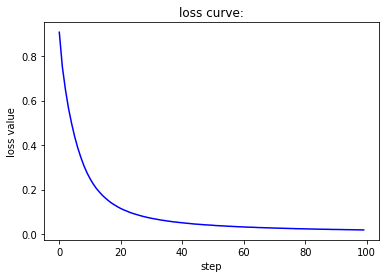

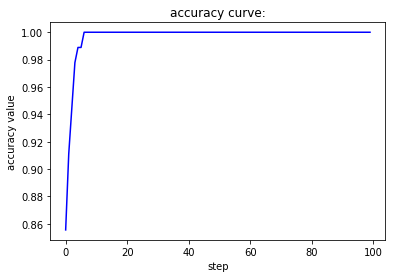

In [29]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 1
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


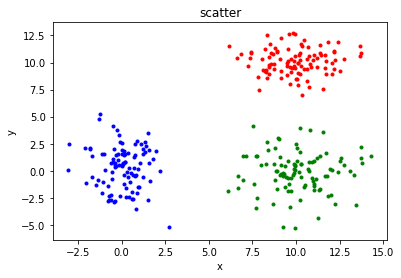

test 0:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 8
current total is: 20
model prediction:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 18
current total is: 40
model prediction:  tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 30
current total is: 60
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
ground truth: tensor([

model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 11
current total is: 20
model prediction:  tensor([1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 22
current total is: 40
model prediction:  tensor([0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 38
current total is: 60
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

test 13:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 36
current total is: 40
model prediction:  tensor([0, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 55
current total is: 60
model prediction:  tensor([2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor

model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 59
current total is: 60
model prediction:  tensor([2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

test 26:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 59
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor

model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 1, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 59
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

test 39:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor

model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0') 

current correct is: 80
current total is: 80
model prediction:  tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0')
ground truth: tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 52:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0

test 58:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor

model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

test 71:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor

model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor

model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       device='cuda:0')
ground truth: tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
       dev

the accuracy of the model is 1.000000
test 97:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       device='cuda:0') 

current correct is: 20
current total is: 20
model prediction:  tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2],
       device='cuda:0') 

current correct is: 40
current total is: 40
model prediction:  tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0')
ground truth: tensor([0, 0, 0, 0, 2, 2, 1, 1, 1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1],
       device='cuda:0') 

current correct is: 60
current total is: 60
model prediction:  tensor([2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2],
      

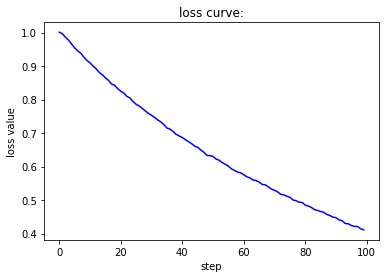

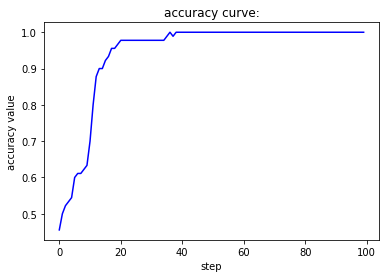

In [30]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 20
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


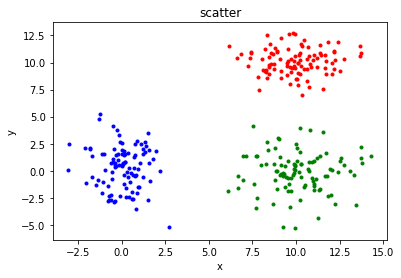

test 0:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 4
current total is: 90
the accuracy of the model is 0.044444
test 1:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2,
 

the accuracy of the model is 0.122222
test 10:----------------------------------------------------------------
model prediction:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
        1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 11
current total is: 90
the accuracy of the model is 0.122222
test 11:----------------------------------------------------------------
model prediction:  tensor([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,

the accuracy of the model is 0.322222
test 20:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 29
current total is: 90
the accuracy of the model is 0.322222
test 21:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,

test 30:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 42
current total is: 90
the accuracy of the model is 0.466667
test 31:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

the accuracy of the model is 0.522222
test 40:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 48
current total is: 90
the accuracy of the model is 0.533333
test 41:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1,

test 50:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 52
current total is: 90
the accuracy of the model is 0.577778
test 51:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

the accuracy of the model is 0.611111
test 60:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 55
current total is: 90
the accuracy of the model is 0.611111
test 61:----------------------------------------------------------------
model prediction:  tensor([1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1,

test 70:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 56
current total is: 90
the accuracy of the model is 0.622222
test 71:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

the accuracy of the model is 0.633333
test 80:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 57
current total is: 90
the accuracy of the model is 0.633333
test 81:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
        1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 60
current total is: 90
the accuracy of the model is 0.666667
test 91:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

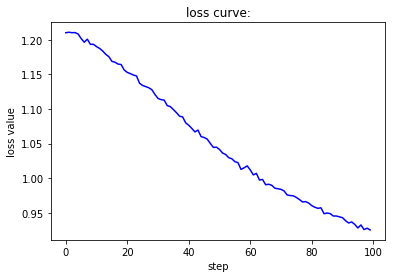

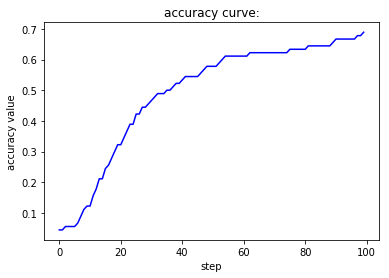

In [31]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 120
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


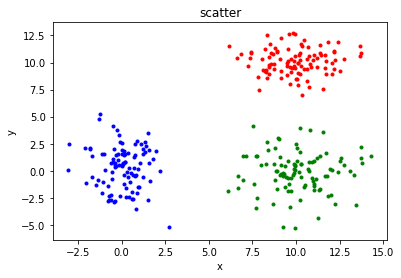

test 0:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 1:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,


test 10:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 11:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

the accuracy of the model is 0.333333
test 20:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 21:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 31:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

test 40:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 41:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

the accuracy of the model is 0.333333
test 50:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 51:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

the accuracy of the model is 0.333333
test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 30
current total is: 90
the accuracy of the model is 0.333333
test 61:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

test 70:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 31
current total is: 90
the accuracy of the model is 0.344444
test 71:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

test 80:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 35
current total is: 90
the accuracy of the model is 0.388889
test 81:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

the accuracy of the model is 0.422222
test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        2, 2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 0,
        0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 39
current total is: 90
the accuracy of the model is 0.433333
test 91:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,

the accuracy of the model is 0.444444


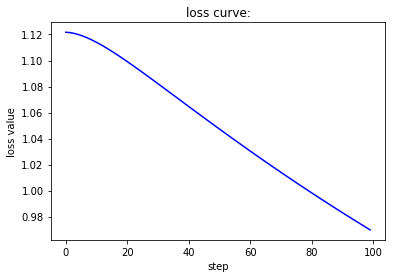

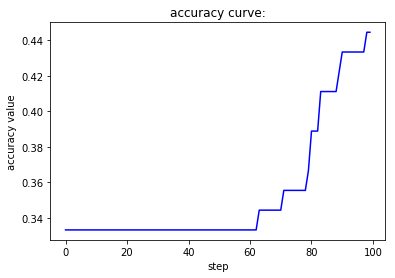

In [32]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 210
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题5:
**使用SGD优化器，并尝试momentum=0, momentum=0.9两种情况, 阐述momentum对loss值以及accuracy值的影响。**

1. 在momentum=0.9的时候，模型的loss能得到更小的值，模型训练的准确率也越高，除此之外，模型的波动性比momentum=0时的波动性更小，当momentum较大时越有可能摆脱局部凹域的束缚。模型超参数初始化的多样性能够导致模型陷入一个局部的最小值当中，momentum的引入优化了这种不确定性，使得梯度的下降朝着全局极值点下降，但由于momentum动量的引入，在模型收敛以后还会存在一定的波动。

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


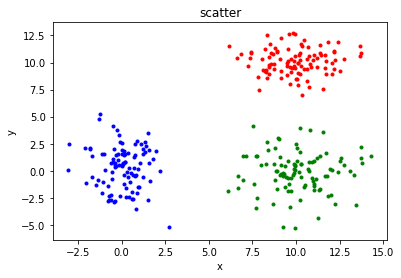

test 0:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 15
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 24
current total is: 64
model prediction:  te

test 6:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 15
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 24
current total is: 64
model prediction:  te

current correct is: 38
current total is: 90
the accuracy of the model is 0.422222
test 12:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 19
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], d

test 18:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 19
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 29
current total is: 64
model prediction:  t

test 24:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 19
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 29
current total is: 64
model prediction:  t

test 30:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 19
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 29
current total is: 64
model prediction:  t

test 36:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 4
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 13
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 20
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 30
current total is: 64
model prediction:  t

test 42:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 5
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 15
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 22
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 32
current total is: 64
model prediction:  t

the accuracy of the model is 0.455556
test 48:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 5
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 15
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 22
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 32
cur

test 54:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 5
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 15
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 22
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 32
current total is: 64
model prediction:  t

test 60:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 6
current total is: 16
model prediction:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 16
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 24
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 34
current total is: 64
model prediction:  t

test 66:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 7
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 19
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 27
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 37
current total is: 64
model prediction:  t

test 72:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 7
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 19
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 28
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 40
current total is: 64
model prediction:  t

the accuracy of the model is 0.633333
test 78:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 9
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 21
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 30
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 43
cur

test 84:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 9
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 22
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 31
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 64
model prediction:  t

test 90:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 9
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 22
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 31
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 64
model prediction:  t

test 96:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 9
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 22
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 31
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 45
current total is: 64
model prediction:  t

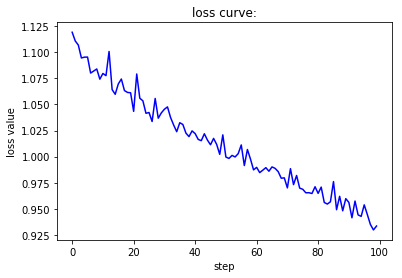

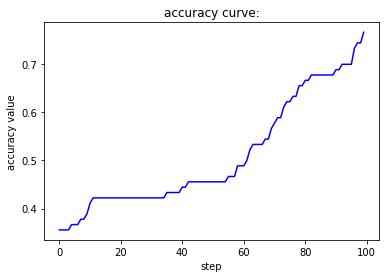

In [33]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


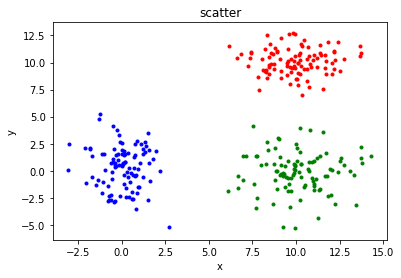

test 0:----------------------------------------------------------------
model prediction:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 7
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 20
current total is: 32
model prediction:  tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 30
current total is: 48
model prediction:  tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 64
model prediction:  te

test 6:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 46
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 62
current total is: 64
model prediction:  t

test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 30
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 59
current total is: 64
model prediction:  

test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 58
current total is: 64
model prediction:  

the accuracy of the model is 0.877778
test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 58
cu

the accuracy of the model is 0.877778
test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 58
cu

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 58
current total is: 64
model prediction:  

test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 58
current total is: 64
model prediction:  

test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 59
current total is: 64
model prediction:  

test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 30
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
current total is: 64
model prediction:  

test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 30
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
current total is: 64
model prediction:  

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 30
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 30
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
current total is: 64
model prediction:  

test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 30
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
current total is: 64
model prediction:  

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 31
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 45
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 61
current total is: 64
model prediction:  

the accuracy of the model is 0.955556
test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 31
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 45
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 61
cu

the accuracy of the model is 0.955556
test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 31
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 45
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 61
cu

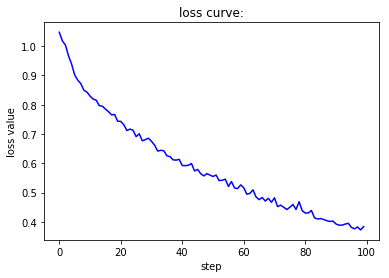

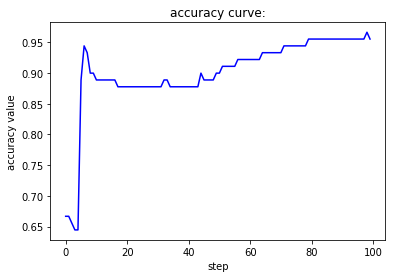

In [34]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题6:
**尝试使用Adam，Rprop优化器，观察两种曲线，阐述SGD,Adam,Rprop三种优化器对loss值以及accuracy值的影响.**

三种优化器最后都让模型取得非常高的accuracy值。
1. SDG：在训练过程中模型收敛得比其他两种优化器收敛得要慢些，loss值存在一些很小的波动，下降比较平缓，accuracy值的波动比较大。
2. Adam：模型收敛得很快，loss值下降比较平缓，accuracy值波动很少，原因是Adam能够对每个不同的参数调整不同的学习率，对频繁变化的参数以更小的步长进行更新，而稀疏的参数以更大的步长进行更新。
3. Rprop：模型收敛得很快，loss值下降很快，accuracy值波动较少。

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


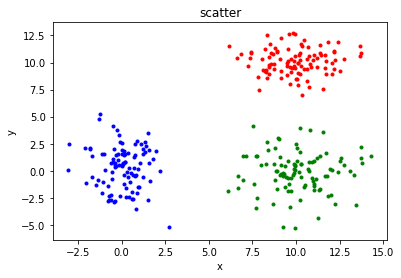

test 0:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 9
current total is: 16
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 18
current total is: 48
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 21
current total is: 64
model prediction:  te

the accuracy of the model is 0.333333
test 6:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 9
current total is: 16
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 12
current total is: 32
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 18
current total is: 48
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 21
curr

the accuracy of the model is 0.377778
test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 10
current total is: 16
model prediction:  tensor([2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 14
current total is: 32
model prediction:  tensor([2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 22
current total is: 48
model prediction:  tensor([2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 26
cu

the accuracy of the model is 0.688889
test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([1, 1, 1, 2, 0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 27
current total is: 32
model prediction:  tensor([2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 40
current total is: 48
model prediction:  tensor([2, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 53
cu

the accuracy of the model is 0.844444
test 24:----------------------------------------------------------------
model prediction:  tensor([1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 11
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 26
current total is: 32
model prediction:  tensor([1, 0, 1, 2, 1, 2, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 39
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 55
cu

the accuracy of the model is 0.800000
test 30:----------------------------------------------------------------
model prediction:  tensor([1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 10
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 25
current total is: 32
model prediction:  tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 36
current total is: 48
model prediction:  tensor([1, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 50
cu

the accuracy of the model is 0.922222
test 36:----------------------------------------------------------------
model prediction:  tensor([2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 14
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 29
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 44
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 60
cu

the accuracy of the model is 0.988889
test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

the accuracy of the model is 1.000000
test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

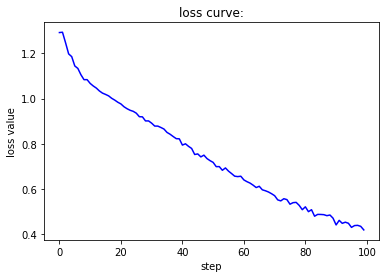

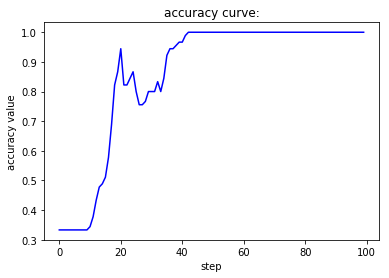

In [37]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.SGD(classifier_net.parameters(), lr=lr, momentum=0.9)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


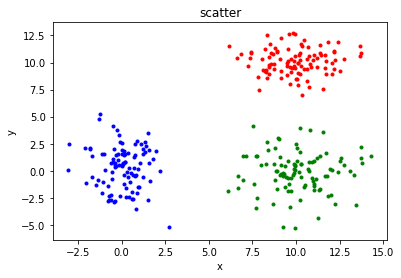

test 0:----------------------------------------------------------------
model prediction:  tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 4
current total is: 16
model prediction:  tensor([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 9
current total is: 32
model prediction:  tensor([0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 13
current total is: 48
model prediction:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 17
current total is: 64
model prediction:  ten

test 6:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 4
current total is: 16
model prediction:  tensor([0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([0, 0, 1, 1, 0, 1, 2, 1, 2, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 17
current total is: 64
model prediction:  te

test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 14
current total is: 16
model prediction:  tensor([2, 2, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 28
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 43
current total is: 48
model prediction:  tensor([1, 2, 2, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 55
current total is: 64
model prediction:  

test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([2, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 31
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 62
current total is: 64
model prediction:  

test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

the accuracy of the model is 1.000000
test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

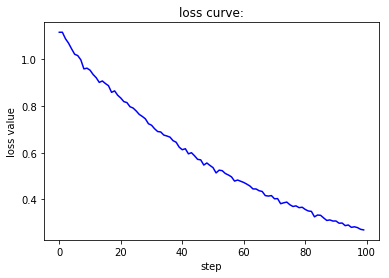

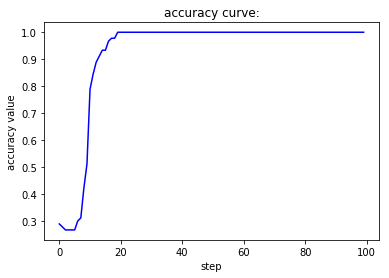

In [35]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.Adam(classifier_net.parameters(), lr=lr)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


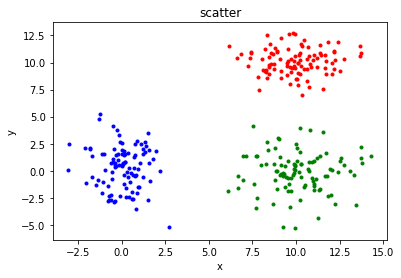

test 0:----------------------------------------------------------------
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 3
current total is: 16
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 10
current total is: 32
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 14
current total is: 48
model prediction:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 23
current total is: 64
model prediction:  te

the accuracy of the model is 0.777778
test 6:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 13
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 26
current total is: 32
model prediction:  tensor([1, 1, 2, 2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 39
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 52
cur

test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 47
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 63
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

the accuracy of the model is 1.000000
test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

current correct is: 80
current total is: 80
model prediction:  tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0')
ground truth: tensor([0, 2, 0, 0, 2, 0, 1, 0, 0, 0], device='cuda:0') 

current correct is: 90
current total is: 90
the accuracy of the model is 1.000000
test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct i

the accuracy of the model is 1.000000
test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

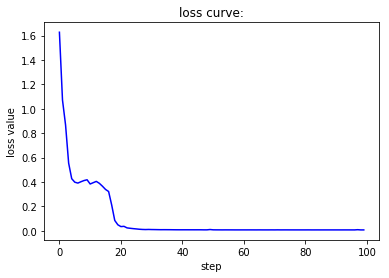

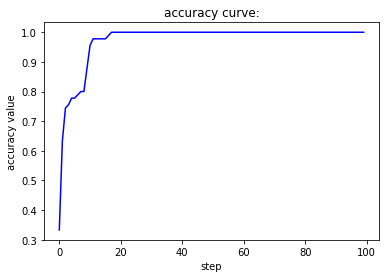

In [36]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-3
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.Rprop(classifier_net.parameters(), lr=lr)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 问题7(自由发挥):
**尝试同时调节以上几种参数，找出你认为最合适的参数（模型收敛得最快），并就此谈谈你的感想.**

在前面调节参数的基础上，为了让模型快速收敛，我们要注意一下几点：
    1. 使用Adam优化器或者Rprop优化器，这两种优化器的收敛速度比SGD优化器的收敛速度要快些。
    2. 学习率的大小设置，不能太大，也不能太小；在学习率太大的时候，模型虽然收敛得很快，但在最后梯度下降太快的时候会错过最优值，所以模型最后的效果可能不是很好。在学习率太小的时候，模型每次下降的梯度太小，虽然收敛的结果很好，但模型收敛速度慢。其实学习率这个参数的调节就是收敛速度跟模型正确率的折中。
    3. batch大小的设置同样不能太大太小；在太大的情况下，虽然更能够表示全局的梯度下降的方向，但对硬件要求比较高，同时模型收敛速度会很慢，但它的潜力非常高；在batch太小的时候，虽然模型收敛的速度很快，但这样容易陷入局部最优解，同时batch较小的时候代表全局梯度下降的程度较低，所以训练过程中波动会非常大。
    4. 所以最后我选择的参数是lr = le-1, batch_size = 16, 优化器使用Rprop。

csv_file source ----> ./labels/train.csv
csv_file source ----> ./labels/test.csv


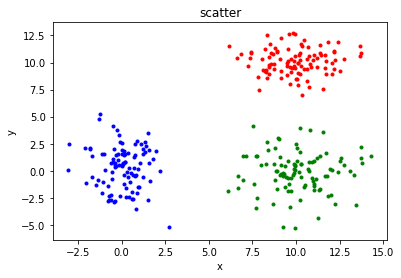

test 0:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  t

the accuracy of the model is 1.000000
test 6:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cur

the accuracy of the model is 1.000000
test 12:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 18:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 24:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 30:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 36:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 42:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 48:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 54:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 60:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 66:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 72:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

the accuracy of the model is 1.000000
test 78:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
cu

test 84:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 90:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

test 96:----------------------------------------------------------------
model prediction:  tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
ground truth: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1], device='cuda:0') 

current correct is: 16
current total is: 16
model prediction:  tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0')
ground truth: tensor([0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0], device='cuda:0') 

current correct is: 32
current total is: 32
model prediction:  tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0')
ground truth: tensor([1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 1], device='cuda:0') 

current correct is: 48
current total is: 48
model prediction:  tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0')
ground truth: tensor([1, 2, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1], device='cuda:0') 

current correct is: 64
current total is: 64
model prediction:  

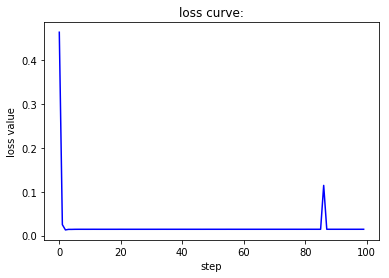

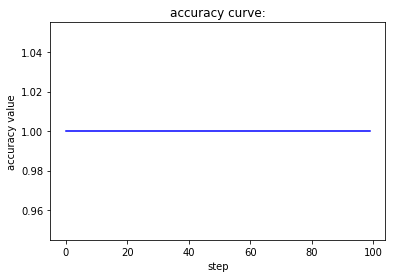

In [46]:
if __name__ == '__main__':
    '''
    change train epoches here
    '''
    # number of training
    epoches = 100
    
    '''
    change learning rate here
    '''
    # learning rate
    # 1e-4 = e^-4
    lr = 1e-1
    
    '''
    change batch size here
    '''
    # batch size
    batch_size = 16
    
    
    
    
    # define a transform to pretreat data
    transform = torch.tensor
    
    # define a gpu device
    device = torch.device('cuda:0')
    
    # define a trainset
    trainset = PointDataset('./labels/train.csv', transform=transform)
    
    # define a trainloader
    trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # define a testset
    testset = PointDataset('./labels/test.csv', transform=transform)
    
    # define a testloader
    testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    show_original_points()

    # define a network
    classifier_net = Network(2, 5, 3).to(device)   
    
    '''
    change optimizer here
    '''    
    # define a optimizer
    optimizer = optim.Rprop(classifier_net.parameters(), lr=lr)
    
    # get trained model
    classifier_net = train(classifier_net, trainloader, testloader, device, lr, optimizer,)

# 作业要求:


# 4. DATA LOADING AND PROCESSING TUTORIAL
# （Further content, read it when you are free）

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

## 4.1. To run this tutorial, please make sure the following packages are installed:
    
- scikit-image: For image io and transforms  

 - sudo apt-get install python-numpy  
 
 - sudo apt-get install python-scipy  
 
 - sudo apt-get install python-matplotlib 
 
 - sudo pip install  scikit-image  
    
- pandas: For easier csv parsing

 - sudo apt-get install python-pandas

In [20]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()   # interactive mode

## 4.2. Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.

In [39]:
# read a csv file by pandas
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 0
# read image name, image name was saved in column 1.
img_name = landmarks_frame.iloc[n, 0]
# points were saved in columns from 2 to the end
landmarks = landmarks_frame.iloc[n, 1:].values
# reshape the formate of points
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 0805personali01.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  27.   83.]
 [  27.   98.]
 [  29.  113.]
 [  33.  127.]]


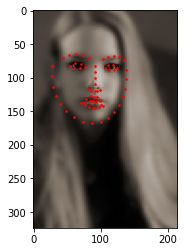

In [40]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

In [42]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        # combine the relative path of images 
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        landmarks = landmarks.astype('float').reshape(-1, 2)
        # save all data we may need during training a network in a dict
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

### Note(very important):
to define a dataset, first we must to inherit the class **torch.utils.data.Dataset**. when we write ourselves dataset, it's neccesarry for us to overload the **\_\___init____** method, **\_\___len____** method, and **\_\___getitem____** method. Of course you can define other method as you like.

## 4.3. Let’s instantiate this class and iterate through the data samples. We will print the sizes of first 4 samples and show their landmarks.

0 (324, 215, 3) (68, 2)


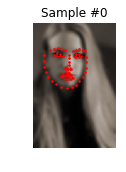

1 (500, 333, 3) (68, 2)


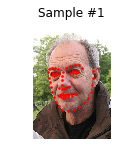

2 (250, 258, 3) (68, 2)


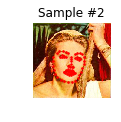

3 (434, 290, 3) (68, 2)


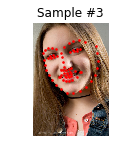

In [43]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    # create subgraph
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

# 5. More materials next week you may need
1. [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
2. [Save Model and Load Model](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
3. [Visualize your training phase](https://github.com/lanpa/tensorboardX)
4. [Exploding and Vanishing Gradients](http://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/readings/L15%20Exploding%20and%20Vanishing%20Gradients.pdf)
5. [Gradient disappearance and gradient explosion in neural network training](https://bzdww.com/article/19659/)
6. [tensorboardX](https://github.com/lanpa/tensorboardX)